# Desafio 5

Neste desafio, vamos praticar sobre redução de dimensionalidade com PCA e seleção de variáveis com RFE. Utilizaremos o _data set_ [Fifa 2019](https://www.kaggle.com/karangadiya/fifa19), contendo originalmente 89 variáveis de mais de 18 mil jogadores do _game_ FIFA 2019.

> Obs.: Por favor, não modifique o nome das funções de resposta.

## _Setup_ geral

In [90]:
from yellowbrick.model_selection import RFECV
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
from loguru import logger
from math import sqrt

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as sct
import seaborn as sns
import statsmodels.api as sm
import statsmodels.stats as st
import warnings
warnings.simplefilter('ignore')

In [3]:
# Algumas configurações para o matplotlib.
%matplotlib inline

from IPython.core.pylabtools import figsize


figsize(12, 8)

sns.set()

In [4]:
fifa = pd.read_csv("fifa.csv")

In [5]:
columns_to_drop = ["Unnamed: 0", "ID", "Name", "Photo", "Nationality", "Flag",
                   "Club", "Club Logo", "Value", "Wage", "Special", "Preferred Foot",
                   "International Reputation", "Weak Foot", "Skill Moves", "Work Rate",
                   "Body Type", "Real Face", "Position", "Jersey Number", "Joined",
                   "Loaned From", "Contract Valid Until", "Height", "Weight", "LS",
                   "ST", "RS", "LW", "LF", "CF", "RF", "RW", "LAM", "CAM", "RAM", "LM",
                   "LCM", "CM", "RCM", "RM", "LWB", "LDM", "CDM", "RDM", "RWB", "LB", "LCB",
                   "CB", "RCB", "RB", "Release Clause"
                   ]

try:
    fifa.drop(columns_to_drop, axis=1, inplace=True)
except KeyError:
    logger.warning(f"Columns already dropped")

## Inicia sua análise a partir daqui

In [6]:
# Sua análise começa aqui.
fifa.head()

,Age,Overall,Potential,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
0,31,94,94,84.0,95.0,70.0,90.0,86.0,97.0,93.0,...,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0
1,33,94,94,84.0,94.0,89.0,81.0,87.0,88.0,81.0,...,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0
2,26,92,93,79.0,87.0,62.0,84.0,84.0,96.0,88.0,...,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0
3,27,91,93,17.0,13.0,21.0,50.0,13.0,18.0,21.0,...,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0
4,27,91,92,93.0,82.0,55.0,92.0,82.0,86.0,85.0,...,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0


In [7]:
fifa.shape

(18207, 37)

In [8]:
fifa.columns

Index(['Age', 'Overall', 'Potential', 'Crossing', 'Finishing',
       'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling', 'Curve',
       'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
       'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
       'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
       'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
       'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling',
       'GKKicking', 'GKPositioning', 'GKReflexes'],
      dtype='object')

In [10]:
fifa.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,18207.0,25.122206,4.669943,16.0,21.0,25.0,28.0,45.0
Overall,18207.0,66.238699,6.908930,46.0,62.0,66.0,71.0,94.0
Potential,18207.0,71.307299,6.136496,48.0,67.0,71.0,75.0,95.0
Crossing,18159.0,49.734181,18.364524,5.0,38.0,54.0,64.0,93.0
Finishing,18159.0,45.550911,19.525820,2.0,30.0,49.0,62.0,95.0
HeadingAccuracy,18159.0,52.298144,17.379909,4.0,44.0,56.0,64.0,94.0
ShortPassing,18159.0,58.686712,14.699495,7.0,54.0,62.0,68.0,93.0
Volleys,18159.0,42.909026,17.694408,4.0,30.0,44.0,57.0,90.0
Dribbling,18159.0,55.371001,18.910371,4.0,49.0,61.0,68.0,97.0
Curve,18159.0,47.170824,18.395264,6.0,34.0,48.0,62.0,94.0


In [35]:
fifa_pivot = pd.DataFrame({'columns': fifa.columns,
                           'types': fifa.dtypes,
                           'nulls': fifa.isna().sum(),
                           '% nulls': fifa.isna().sum() / fifa.shape[0],
                           'size': fifa.shape[0],
                           'uniques': fifa.nunique()})
fifa_pivot

,columns,types,nulls,% nulls,size,uniques
Age,Age,int64,0,0.0,18159,29
Overall,Overall,int64,0,0.0,18159,48
Potential,Potential,int64,0,0.0,18159,47
Crossing,Crossing,float64,0,0.0,18159,89
Finishing,Finishing,float64,0,0.0,18159,93
HeadingAccuracy,HeadingAccuracy,float64,0,0.0,18159,91
ShortPassing,ShortPassing,float64,0,0.0,18159,85
Volleys,Volleys,float64,0,0.0,18159,87
Dribbling,Dribbling,float64,0,0.0,18159,94
Curve,Curve,float64,0,0.0,18159,89


**Pela análise do gráfico abaixo vemos que o percentual de nulos esta entre 0 e 20%**

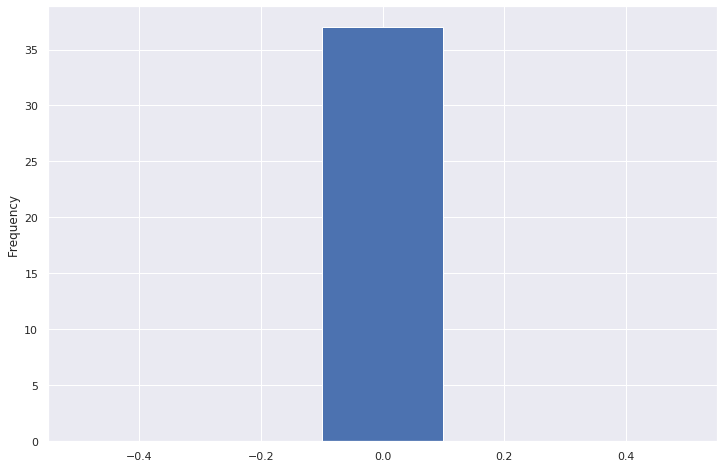

In [41]:
fifa_pivot['% nulls'].plot.hist(bins=5)

**Dropando os valores nulos, pois funções de PCA não os aceita**

In [26]:
fifa.dropna(inplace=True)

In [42]:
fifa.columns

Index(['Age', 'Overall', 'Potential', 'Crossing', 'Finishing',
       'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling', 'Curve',
       'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
       'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
       'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
       'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
       'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling',
       'GKKicking', 'GKPositioning', 'GKReflexes'],
      dtype='object')

## Questão 1

Qual fração da variância consegue ser explicada pelo primeiro componente principal de `fifa`? Responda como um único float (entre 0 e 1) arredondado para três casas decimais.

In [89]:
def q1():
    pca = PCA().fit(fifa)

    return float(pca.explained_variance_ratio_[0].round(3))


q1()

0.565

## Questão 2

Quantos componentes principais precisamos para explicar 95% da variância total? Responda como un único escalar inteiro.

In [27]:
def q2():
    pca = PCA(n_components=0.95)
    fifa_reduced = pca.fit_transform(fifa)

    return fifa_reduced.shape[1]


q2()

15

**Visualizando o momento em que bateu os 95% de importancia em gráficos**

In [81]:
pca = PCA().fit(fifa)
evr = pca.explained_variance_ratio_

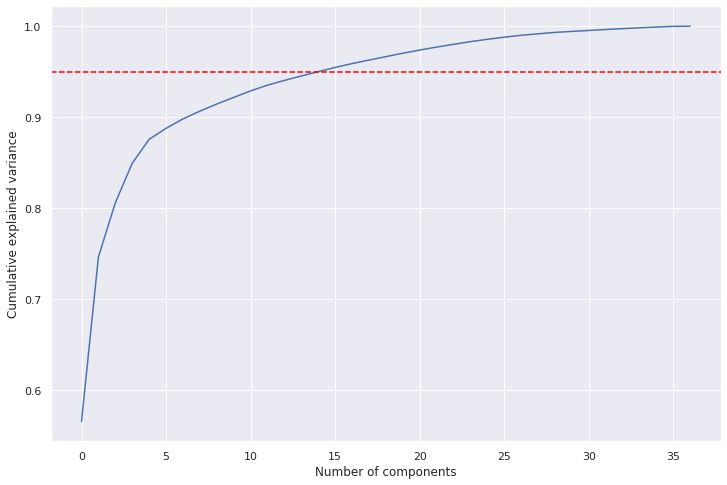

In [82]:
g = sns.lineplot(np.arange(len(evr)), np.cumsum(evr))
g.axes.axhline(0.95, ls="--", color="red")
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

## Questão 3

Qual são as coordenadas (primeiro e segundo componentes principais) do ponto `x` abaixo? O vetor abaixo já está centralizado. Cuidado para __não__ centralizar o vetor novamente (por exemplo, invocando `PCA.transform()` nele). Responda como uma tupla de float arredondados para três casas decimais.

In [46]:
x = [0.87747123,  -1.24990363,  -1.3191255, -36.7341814,
     -35.55091139, -37.29814417, -28.68671182, -30.90902583,
     -42.37100061, -32.17082438, -28.86315326, -22.71193348,
     -38.36945867, -20.61407566, -22.72696734, -25.50360703,
     2.16339005, -27.96657305, -33.46004736,  -5.08943224,
     -30.21994603,   3.68803348, -36.10997302, -30.86899058,
     -22.69827634, -37.95847789, -22.40090313, -30.54859849,
     -26.64827358, -19.28162344, -34.69783578, -34.6614351,
     48.38377664,  47.60840355,  45.76793876,  44.61110193,
     49.28911284
     ]

In [49]:
def q3():
    pca = PCA(n_components=2).fit(fifa)

    return tuple(pca.components_.dot(x).round(3))


q3()

(186.556, -6.592)

## Questão 4

Realiza RFE com estimador de regressão linear para selecionar cinco variáveis, eliminando uma a uma. Quais são as variáveis selecionadas? Responda como uma lista de nomes de variáveis.

In [84]:
regression = LinearRegression()

X = fifa.drop(columns='Overall')
y = fifa['Overall']

In [83]:
def q4():
    rfe = RFE(regression, n_features_to_select=5)
    rfe = rfe.fit(X, y)

    return list(X.loc[:, rfe.support_].columns)


q4()

['Age', 'Potential', 'BallControl', 'Reactions', 'GKReflexes']

**Vendo de forma gráfica qual séria o melhor numero de features**

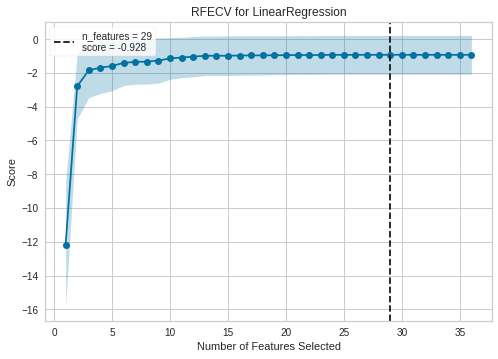

In [91]:
visualizer = RFECV(regression)
visualizer.fit(X, y)
visualizer.show()

Após visualizar o gráfico ficou claro que acima de 10 features não existe uma grande diferença no score do modelo